### Visualizing the distribution of the observations

### Load the required libraries

In [5]:
sc.stop()

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSBBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12152
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     4|[80 CD 30 D5 80 C...|1990.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     0|[E0 55 F0 56 00 0...|1991.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     1|[A0 53 A0 53 80 C...|1992.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|    17|[80 D1 40 D6 00 C...|1993.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     1|[80 54 40 56 A0 5...|1994.0|SSSBSBBS|
+---------+--------+---------+-----------+-----------+------+-------------

In [4]:
# Number of stations in my dataset
df.select('station').distinct().count()

135

### Select data for a particular station and measurement type

In [5]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USS0019L17S')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USS0019L17S'
18 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2804.2| 38.4333|-119.3667|       PRCP|USS0019L17S|     2|[00 00 00 00 00 0...|1979.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       PRCP|USS0019L17S|     2|[00 00 00 00 90 5...|1980.0|SSSBSBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(18, 365)

In [6]:
#38.5246° N, 118.6246° W

In [7]:
# similar to query above
Hawthorne_Query="SELECT * FROM weather\n\tWHERE latitude BEWTEEN '%s' and '%s' AND longitude ='%s'" ##%('PRCP','USS0019L17S')
print Hawthorne_Query
Haw_df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE latitude BEWTEEN '%s' and '%s' AND longitude ='%s'
18 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2804.2| 38.4333|-119.3667|       PRCP|USS0019L17S|     2|[00 00 00 00 00 0...|1979.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       PRCP|USS0019L17S|     2|[00 00 00 00 90 5...|1980.0|SSSBSBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(18, 365)

In [8]:
df1[df1.measurement=='PRCP']

DataFrame[elevation: double, latitude: double, longitude: double, measurement: string, station: string, undefs: bigint, vector: binary, year: double, label: string]

### Script for plotting yearly plots

In [9]:
len(T)

18

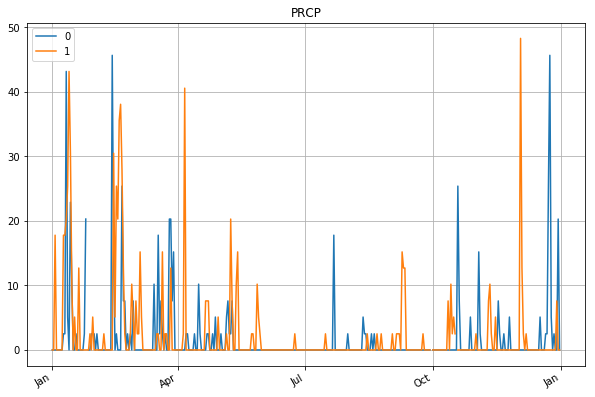

In [10]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [11]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/root/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


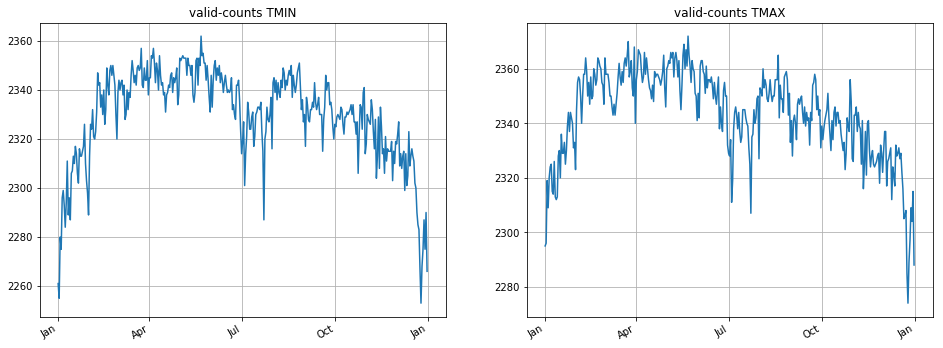

In [12]:
plot_pair(['TMIN','TMAX'],plot_valid)

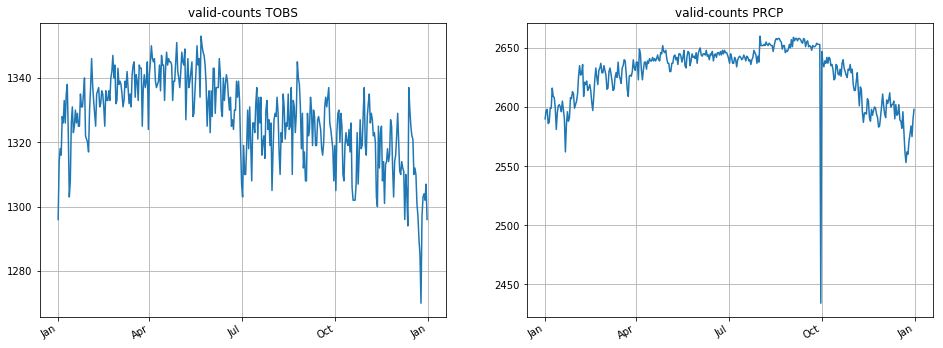

In [13]:
plot_pair(['TOBS','PRCP'],plot_valid)

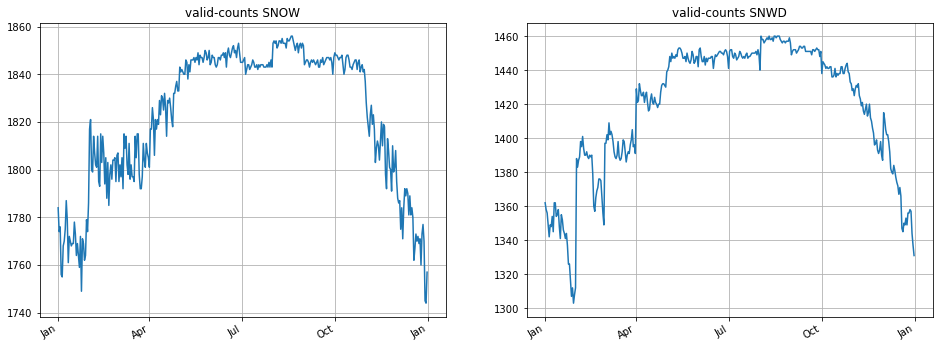

In [14]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [15]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    if m in ['TMIN','TMAX','TOBS']:
        graphs = graphs/10
        ylabel='Degree Celsius'
    else:
        ylabel='millimeters'
    YP.plot(graphs,fig,axis,labels = ['Mean-Std','Mean','Mean+Std'], xlabel='Months', ylabel=ylabel,  title='Mean+-std   '+m)

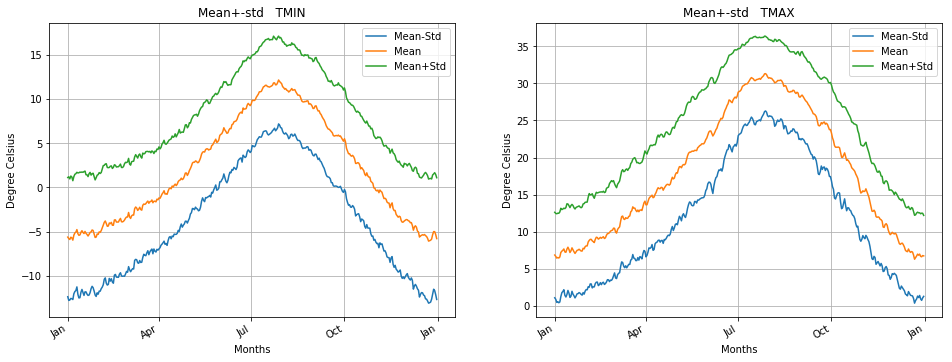

In [16]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

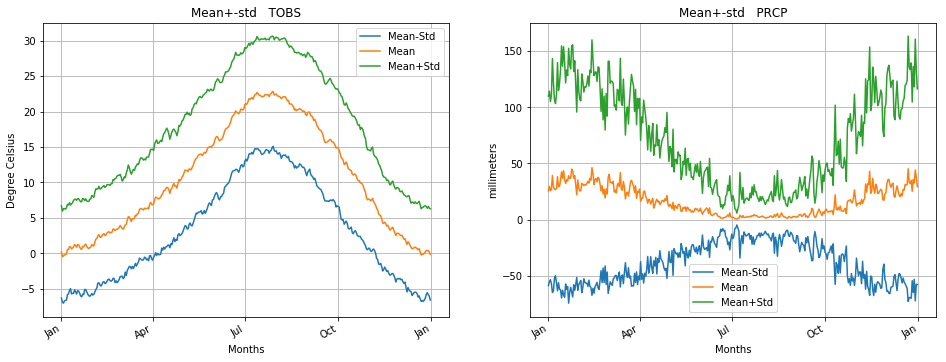

In [17]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

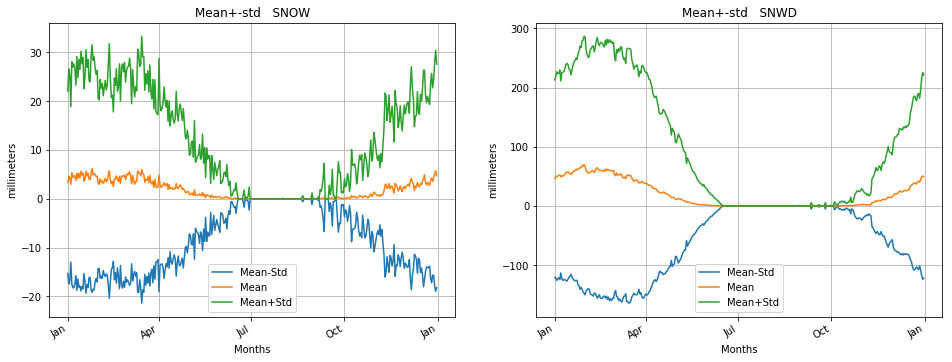

In [18]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [19]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

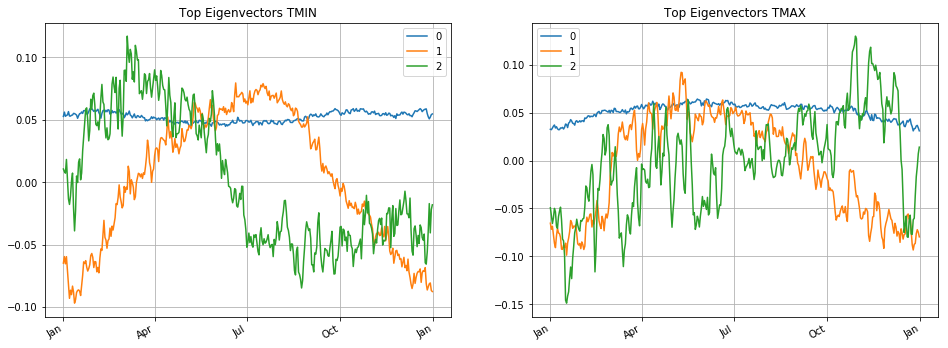

In [20]:
plot_pair(['TMIN','TMAX'],plot_eigen)

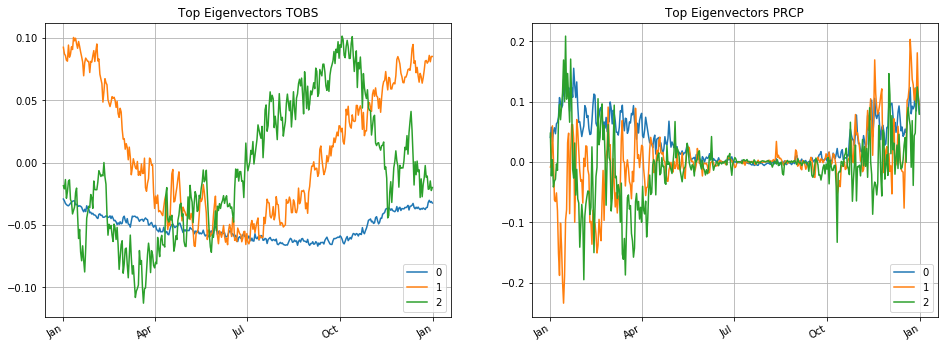

In [21]:
plot_pair(['TOBS','PRCP'],plot_eigen)

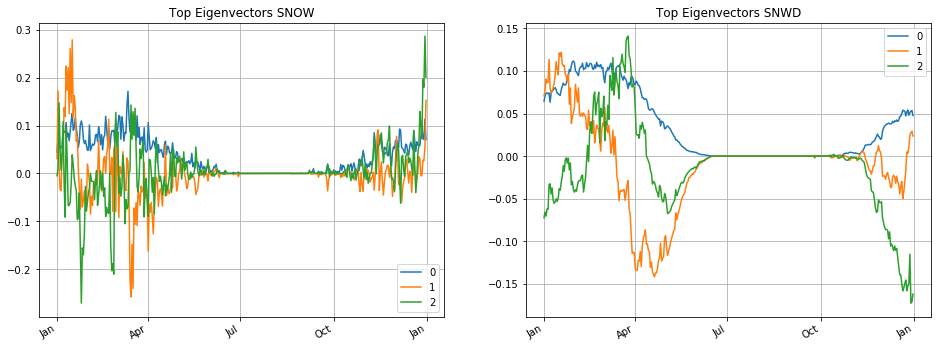

In [22]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [23]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# of Eigenvectors')
    grid()
    

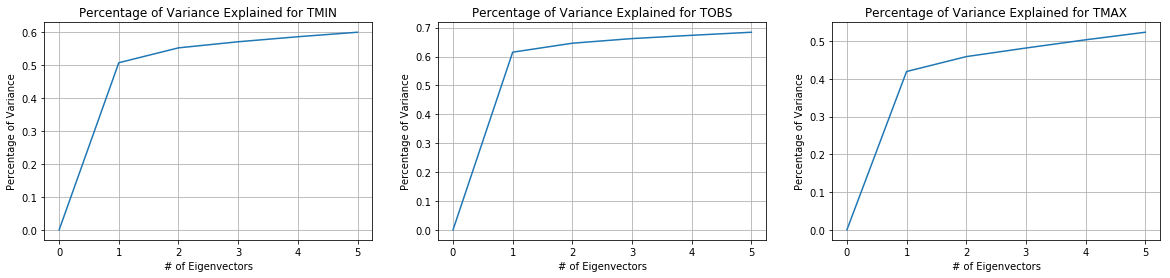

In [24]:
f=plt.figure(figsize=(20,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

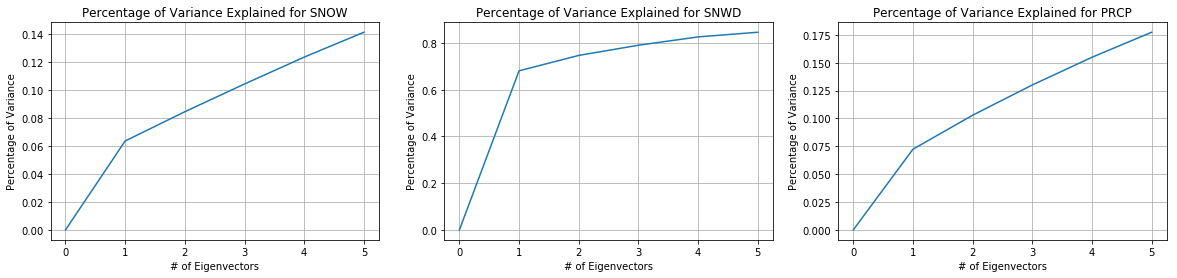

In [25]:
f=plt.figure(figsize=(20,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [26]:
#sc.stop()

In [27]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, elevation, latitude, longitude, vector, year FROM weather\n\tWHERE measurement='%s'"%('SNWD')
df1 = sqlContext.sql(Query)
rows=df1.rdd.map(lambda row:[unpackArray(row['vector'],np.float16), row['station'], row['elevation'], row['latitude'], row['longitude'], row['year']]).collect()
data = pd.DataFrame(rows, columns=('vector', 'station', 'elevation', 'latitude', 'longitude', 'year'))


In [28]:
data_with_SNWD = (data['vector'][data['vector'].apply(lambda x: np.nansum(x)) >0].count())*1.0
total_data_size = (data.shape[0])*1.0
print data_with_SNWD/total_data_size *100, '% of total instances have records for SNWD'

64.2759562842 % of total instances have records for SNWD


In [29]:
data['SNWD_sum'] = data['vector'].apply(lambda x: np.nansum(x))

data['SNWD_bin'] = data['SNWD_sum'].apply(lambda x: 1 if x > 0 else 0)

In [30]:
np.max(data.elevation) - np.min(data.elevation)

2466.1999999999998

In [31]:
np.max(data.elevation)

2551.1999999999998

In [32]:
np.min(data.elevation)

85.0

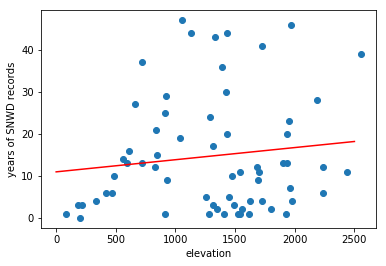

In [78]:
a = data.groupby('elevation')['SNWD_bin'].sum()
plt.scatter(a.index, a.values)
plt.plot([0,2500],[10.9449,18.1688], color='red')
plt.xlabel('elevation')
plt.ylabel('years of SNWD records')

In [65]:
from scipy.stats import linregress
linregress(a.index, a.values)

LinregressResult(slope=0.0028895563667616425, intercept=10.944918325139755, rvalue=0.12637789164354488, pvalue=0.31969074816629039, stderr=0.0028805013757144992)

In [75]:
2500*0.0028895563667616425+10.944918325139755

18.16880924204386

In [80]:
type(data)

pandas.core.frame.DataFrame

In [83]:
len(data)

1464

In [112]:
data2 = data

In [116]:
data2.head()

,vector,station,elevation,latitude,longitude,year,SNWD_sum,SNWD_bin
0,0. 0. 0. 0. 0. 0. 0. 0...,USC00048969,1539.8,38.6000,-119.4833,1954.0,660.0,1
1,nan nan nan nan 0. 0. 0. 0...,USC00262948,1410.9,38.8667,-117.9167,2012.0,330.0,1
2,0. 102. 76. 76. 51. 0. 0. 51...,USC00049583,723.0,38.3833,-120.5667,1950.0,1981.0,1
3,0. 0. 0. 0. 0. 0. 0. 0. 0. ...,USC00049583,723.0,38.3833,-120.5667,1951.0,0.0,0
4,0. 0. 0. 0. 0. 76. 0. 0. 0. ...,USC00049583,723.0,38.3833,-120.5667,1952.0,203.0,1


In [129]:
d2 = pd.to_numeric(data2.vector[0], errors='ignore')

In [131]:
len(d2)

2216

In [8]:
### Function to extract the values 
measures = ['TOBS', 'TMIN', 'TMAX', 'PRCP', 'SNOW', 'SNWD']
data = []
for i in measures:
    sqlContext.registerDataFrameAsTable(df,'weather')
    Query="SELECT station, vector FROM weather\n\tWHERE measurement='%s'"%(i)
    df1 = sqlContext.sql(Query)
    rows=df1.rdd.map(lambda row:[unpackArray(row['vector'],np.float16), row['station']]).collect()
    measure = pd.DataFrame(rows, columns=('vector', 'station'))
    data.append(measure)

In [10]:
for i in range(0,4):
    data[i]['Jan_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[:31])/10)
    data[i]['Feb_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[31:59])/10)
    data[i]['Mar_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[59:90])/10)
    data[i]['Apr_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[90:120])/10)
    data[i]['May_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[120:151])/10)
    data[i]['Jun_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[151:181])/10)
    data[i]['Jul_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[181:212])/10)
    data[i]['Aug_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[212:243])/10)
    data[i]['Sep_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[243:273])/10)
    data[i]['Oct_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[273:304])/10)
    data[i]['Nov_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[304:334])/10)
    data[i]['Dec_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[334:])/10)
    data[i]['All_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x/10))
    data[i] = data[i].groupby('station').mean()
for i in range(4,6):
    data[i]['Jan_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[:31]))
    data[i]['Feb_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[31:59]))
    data[i]['Mar_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[59:90]))
    data[i]['Apr_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[90:120]))
    data[i]['May_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[120:151]))
    data[i]['Jun_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[151:181]))
    data[i]['Jul_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[181:212]))
    data[i]['Aug_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[212:243]))
    data[i]['Sep_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[243:273]))
    data[i]['Oct_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[273:304]))
    data[i]['Nov_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[304:334]))
    data[i]['Dec_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x[334:]))
    data[i]['All_%s' %measures[i]] = data[i]['vector'].apply(lambda x: np.nanmean(x))
    data[i] = data[i].groupby('station').mean()

In [11]:
data = pd.concat([data[0], data[1], data[2], data[3], data[4], data[5]], axis=1, join='inner')
print data.shape

(47, 78)


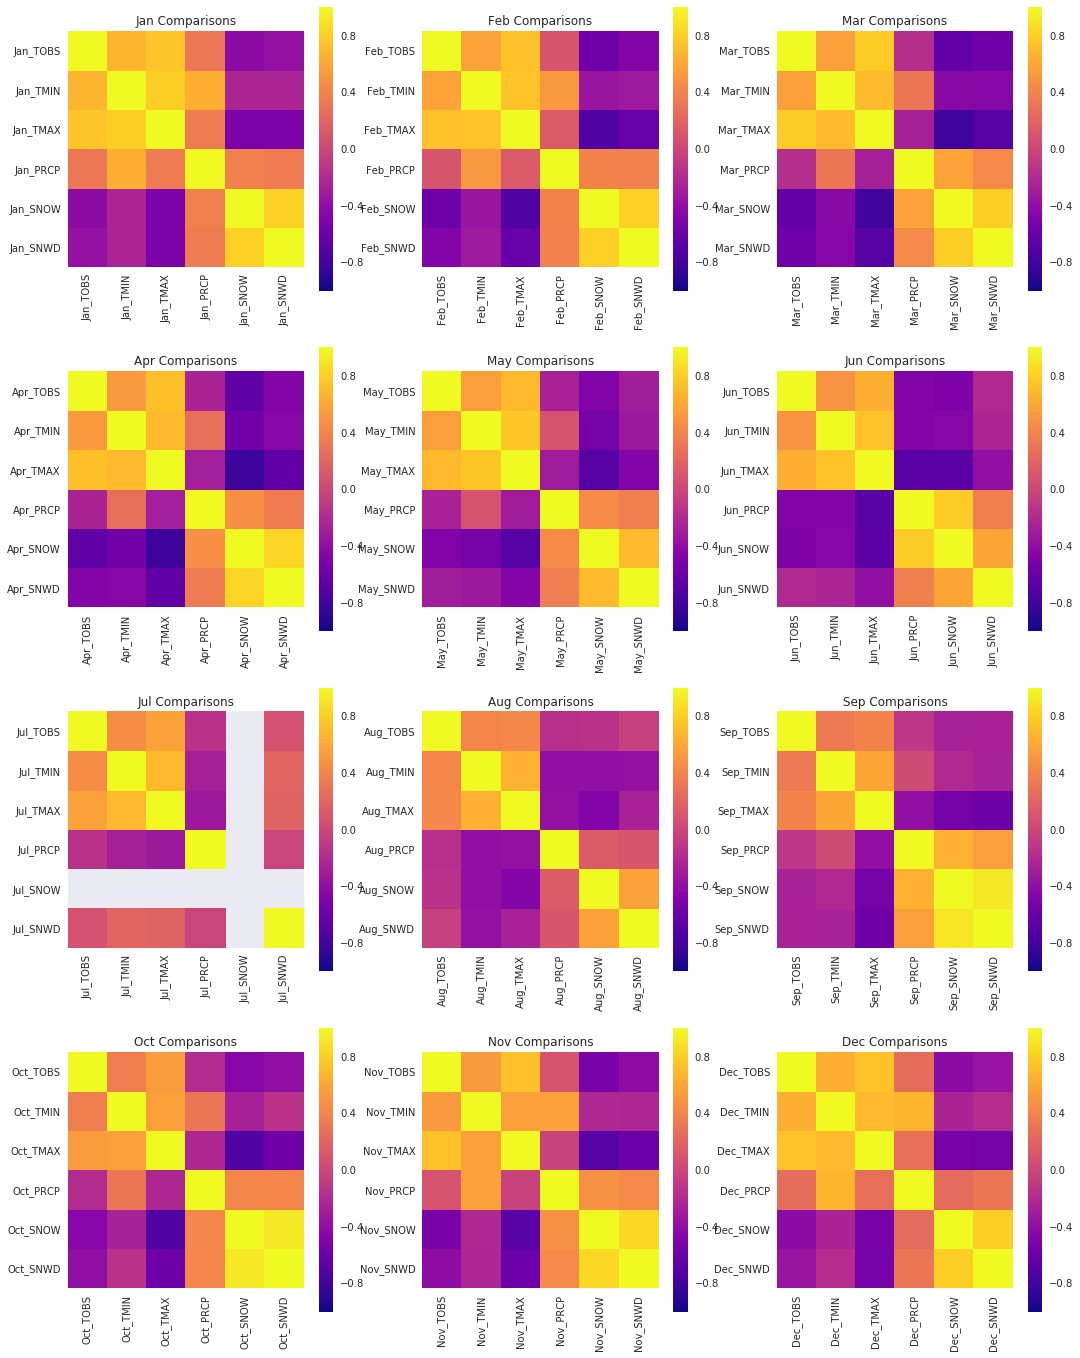

In [26]:
import seaborn as sns

num_plots = 12
fig, axes = plt.subplots(4,3,figsize=(18,24))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i in range(len(months)):
    a = data.filter(regex=months[i])
    #mat = a.cov() # to get a heatmap of the covariance matrix
    mat = a.corr() # to get a heatmap of the correlation matrix
    row = i // 3
    col = i % 3
    ax_curr = axes[row, col]
    sns.heatmap(mat, vmax=1, square = True, ax=ax_curr, cmap='plasma') #"gnuplot2")
    ax_curr.set_title('%s Comparisons' %months[i])

In [15]:
data2 = data[data[['ALL_TOBS','ALL_TMIN']]]

KeyError: "['ALL_TOBS' 'ALL_TMIN'] not in index"

In [40]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'All']

b = data.filter(regex=months[12])
    #mat = a.cov() # to get a heatmap of the covariance matrix
mat2 = b.corr() # to get a heatmap of the correlation matrix
# row = i // 3
# col = i % 3
#ax_curr = axes[row, col]
sns.heatmap(mat2, vmax=1, square = True, ax=ax_curr, cmap='plasma') #"gnuplot2")


   Correlation Heatmap (Annual Averages)


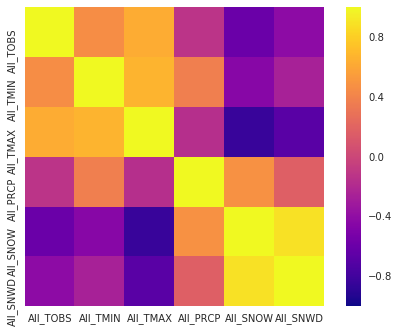

In [39]:
print('   Correlation Heatmap (Annual Averages)')
sns.heatmap(mat2, vmax=1, square = True, cmap='plasma'); 
